# 高维线性回归实验

$$y=0.05+\sum_{i=1}^p 0.01x_i+\epsilon$$

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

In [2]:
n_train = 20  # 训练集数量
n_test = 100  # 测试集数量
num_inputs = 200  # p=200，200个特征
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float)

train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

# 从零开始实现

## 初始化模型参数

In [3]:
def init_params():
    w = torch.randn((num_inputs, 1),
                    requires_grad=True)
    b = torch.zeros(1,
                    requires_grad=True)
    return [w, b]

## 定义$L_2$范数惩罚项

只惩罚模型的权重参数

In [4]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

## 定义训练和测试

In [5]:
batch_size = 1
num_epochs = 100
lr = 0.003

net = d2l.linreg
loss = d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()  # 计算梯度
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    # norm() 求范数
    print('L2 norm of w:', w.norm().item())

## 观察过拟合

当lambd设为0时，我们没有使用权重衰减。结果训练误差远小于测试集上的误差。这是典型的过拟合现象。

L2 norm of w: 14.051960945129395


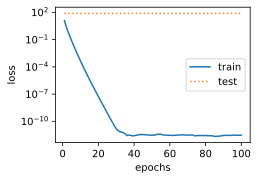

In [6]:
fit_and_plot(lambd=0)

## 使用权重衰减

可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解。另外，权重参数的$L2$
范数比不使用权重衰减时的更小，此时的权重参数更接近0。

L2 norm of w: 0.029283160343766212


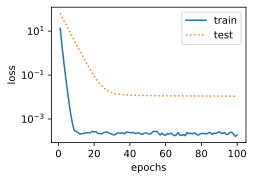

In [7]:
fit_and_plot(lambd=3)

# 简洁实现

In [8]:
def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般以weight结尾
    # 定义模型
    net = nn.Linear(num_inputs, 1)
    # 初始化模型参数
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 梯度下降法
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            
            # 梯度清零
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()  # 梯度计算
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 13.652609825134277


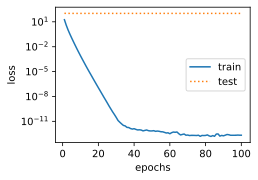

In [9]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.03545144572854042


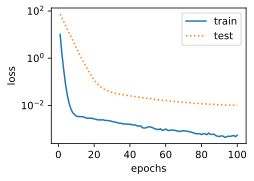

In [10]:
fit_and_plot_pytorch(3)